In [ ]:
import sys
sys.path.append("..")
from datasets import load_dataset
from typing import Any
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tgs_project.utils import load_cnn_dailymail

dataset = load_cnn_dailymail()
# Get basic information about the dataset
print(dataset)


True

## Look at Article Length

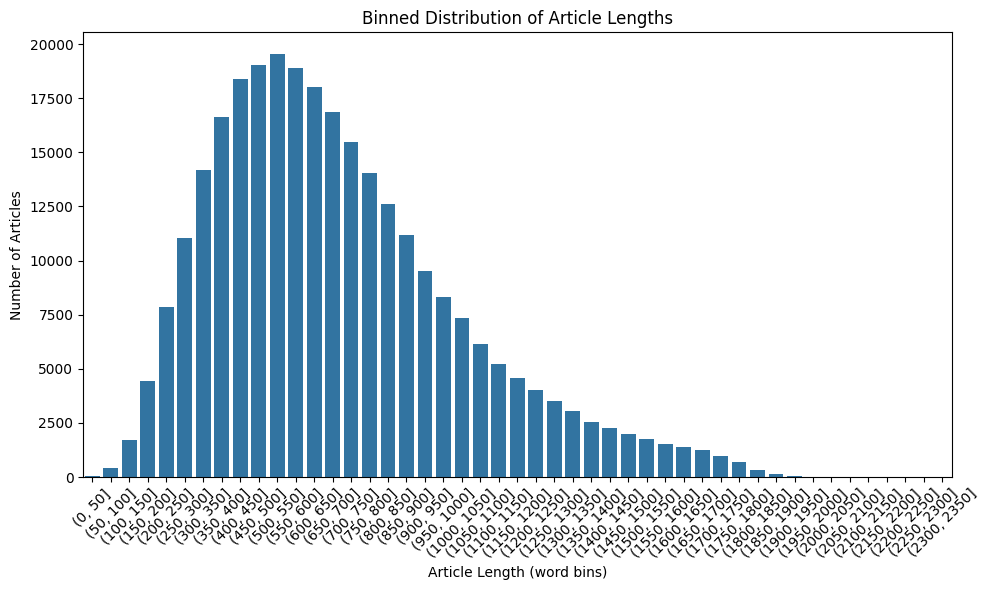

In [42]:
from collections import Counter
train_article_length_distribution = Counter(
    len(article['article'].split()) for article in dataset['train']
)

# Convert Counter to DataFrame
df = pd.DataFrame(train_article_length_distribution.items(), columns=["length", "count"])
df["length_bin"] = pd.cut(df["length"], bins=range(0, df["length"].max() + 50, 50))

# Aggregate counts by bin
binned = df.groupby("length_bin", observed=False)["count"].sum().reset_index()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x="length_bin", y="count", data=binned)
plt.xlabel("Article Length (word bins)")
plt.ylabel("Number of Articles")
plt.title("Binned Distribution of Article Lengths")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Get Number of Unique IDs

In [43]:
articles = dataset["train"]  # type: ignore
n_articles = len(articles)
all_ids = set()
for article in articles:
    all_ids.add(article["id"])
print(f"Number of unique IDs: {len(all_ids)}")
print(f"Number of articles: {n_articles}")

Number of unique IDs: 287113
Number of articles: 287113


### The top mentioned people in the News Articles

In [2]:
import requests

# Solr configuration
SOLR_URL = "http://localhost:8983/solr"
COLLECTION = "articles"  # replace with your actual collection

# Facet field
facet_field = "ner_PERSON"  # replace with the field you want to facet on

# Build the query
params = {
    "q": "*:*",
    "rows": 0,
    "facet": "true",
    "facet.field": facet_field,
    "facet.limit": 20,  # optional: top 10 terms
    "wt": "json"
}

# Send request
response = requests.get(f"{SOLR_URL}/{COLLECTION}/select", params=params)
response.raise_for_status()
data = response.json()

# Print facet results
facets = data.get("facet_counts", {}).get("facet_fields", {}).get(facet_field, [])
facet_results = list(zip(facets[::2], facets[1::2]))  # (term, count) pairs
for term, count in facet_results:
    print(f"{term}: {count}")


Obama: 15001
Barack Obama: 11575
David Cameron: 7140
Cameron: 4188
David: 3118
Brown: 2959
Smith: 2929
Hillary Clinton: 2795
James: 2758
Bush: 2739
John: 2728
Johnson: 2721
Clinton: 2616
Michael: 2588
Williams: 2466
Wayne Rooney: 2378
William: 2253
Jones: 2209
Louis van Gaal: 2202
Kate: 2133


### Looking at the context of the found terms

In [12]:
COLLECTION = "context_windows"  # replace with your actual collection

# Facet field
facet_field = "article_context_windows_str"  # replace with the field you want to facet on

# Build the query
params = {
    "q": "article_context_windows:obama",
    "rows": 0,
    "facet": "true",
    "facet.field": facet_field,
    "facet.limit": 20,  
    "wt": "json"
}

# Send request
response = requests.get(f"{SOLR_URL}/{COLLECTION}/select", params=params)
response.raise_for_status()
data = response.json()

# Print facet results
facets = data.get("facet_counts", {}).get("facet_fields", {}).get(facet_field, [])
facet_results = list(zip(facets[::2], facets[1::2]))  # (term, count) pairs
for term, count in facet_results:
    print(f"{term}: {count}")


, " Obama said .: 859
, " Obama said in: 270
. The Obama administration has: 219
, ' Obama said .: 211
, " Obama said ,: 170
, " Obama said at: 118
President Barack Obama , who: 101
President Barack Obama and his: 87
, the Obama administration has: 75
. The Obama administration is: 73
, ' Obama said in: 62
, " Obama told reporters: 61
, ' Obama said ,: 60
Obama and first lady Michelle: 58
by the Obama administration .: 52
of the Obama administration .: 52
President Barack Obama said he: 50
President Barack Obama said the: 50
, the Obama administration is: 49
a senior Obama administration official: 49


In [7]:
data

{'responseHeader': {'status': 0,
  'QTime': 0,
  'params': {'q': '*:*',
   'facet.limit': '20',
   'facet.field': 'sentences',
   'rows': '0',
   'facet': 'true',
   'wt': 'json'}},
 'response': {'numFound': 287113,
  'start': 0,
  'numFoundExact': True,
  'docs': []},
 'facet_counts': {'facet_queries': {},
  'facet_fields': {'sentences': []},
  'facet_ranges': {},
  'facet_intervals': {},
  'facet_heatmaps': {}}}